# Image Classification using Logistic Regression in PyTorch



In [7]:
# Imports
import torch
import torchvision
from torchvision.datasets import MNIST

In [8]:
# Download training dataset
dataset = MNIST(root='data/', download=True)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [9]:
len(dataset)

60000

In [10]:
test_dataset = MNIST(root='data/', train=False)
len(test_dataset)

10000

In [11]:
dataset[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x7FF66773B9D0>, 5)

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

Label: 5


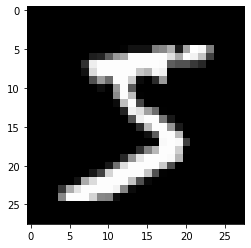

In [13]:
image, label = dataset[0]
plt.imshow(image, cmap='gray')
print('Label:', label)

Label: 3


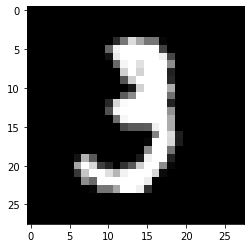

In [14]:
image, label = dataset[10]
plt.imshow(image, cmap='gray')
print('Label:', label)

In [15]:
import torchvision.transforms as transforms

PyTorch datasets allow us to specify one or more transformation functions which are applied to the images as they are loaded. `torchvision.transforms` contains many such predefined functions, and we'll use the `ToTensor` transform to convert images into PyTorch tensors.

In [16]:
# MNIST dataset (images and labels)
dataset = MNIST(root='data/', 
                train=True,
                transform=transforms.ToTensor())

In [17]:
img_tensor, label = dataset[0]
print(img_tensor.shape, label)

torch.Size([1, 28, 28]) 5


The image is now converted to a 1x28x28 tensor. The first dimension is used to keep track of the color channels. Since images in the MNIST dataset are grayscale, there's just one channel. Other datasets have images with color, in which case there are 3 channels: red, green and blue (RGB). Let's look at some sample values inside the tensor:

## Training and Validation Datasets

We will split the dataset into 3 parts:

1. **Training set** - used to train the model i.e. compute the loss and adjust the weights of the model using gradient descent.
2. **Validation set** - used to evaluate the model while training, adjust hyperparameters (learning rate etc.) and pick the best version of the model.
3. **Test set** - used to compare different models, or different types of modeling approaches, and report the final accuracy of the model.


In [20]:
from torch.utils.data import random_split

train_ds, val_ds = random_split(dataset, [50000, 10000])
len(train_ds), len(val_ds)

(50000, 10000)

In [21]:
from torch.utils.data import DataLoader

batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

## Model

Now that we have prepared our data loaders, we can define our model.

* A **logistic regression** model there are weights and bias matrices, and the output is obtained using simple matrix operations (`pred = x @ w.t() + b`). 

* Just as we did with linear regression, we can use `nn.Linear` to create the model instead of defining and initializing the matrices manually.

* Since `nn.Linear` expects the each training example to be a vector, each `1x28x28` image tensor needs to be flattened out into a vector of size 784 (`28*28`), before being passed into the model. 

* The output for each image is vector of size 10, with each element of the vector signifying the probability a particular target label (i.e. 0 to 9). The predicted label for an image is simply the one with the highest probability.

In [22]:
import torch.nn as nn

input_size = 28*28
num_classes = 10


In [26]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
model = MnistModel()

Inside the `__init__` constructor method, we instantiate the weights and biases using `nn.Linear`. And inside the `forward` method, which is invoked when we pass a batch of inputs to the model, we flatten out the input tensor, and then pass it into `self.linear`.

`xb.reshape(-1, 28*28)` indicates to PyTorch that we want a *view* of the `xb` tensor with two dimensions, where the length along the 2nd dimension is 28\*28 (i.e. 784). One argument to `.reshape` can be set to `-1` (in this case the first dimension), to let PyTorch figure it out automatically based on the shape of the original tensor.

Note that the model no longer has `.weight` and `.bias` attributes (as they are now inside the `.linear` attribute), but it does have a `.parameters` method which returns a list containing the weights and bias, and can be used by a PyTorch optimizer.

In [27]:
print(model.linear.weight.shape, model.linear.bias.shape)
list(model.parameters())

torch.Size([10, 784]) torch.Size([10])


[Parameter containing:
 tensor([[ 0.0250,  0.0204, -0.0054,  ...,  0.0309,  0.0143,  0.0147],
         [-0.0193, -0.0254, -0.0179,  ...,  0.0045, -0.0046,  0.0044],
         [ 0.0289,  0.0057, -0.0290,  ..., -0.0087, -0.0084, -0.0224],
         ...,
         [ 0.0011, -0.0044, -0.0010,  ..., -0.0271, -0.0247,  0.0112],
         [-0.0092, -0.0029, -0.0236,  ...,  0.0102, -0.0234,  0.0029],
         [-0.0238,  0.0281,  0.0019,  ...,  0.0344,  0.0035,  0.0306]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.0287,  0.0224, -0.0194, -0.0129, -0.0257,  0.0344,  0.0140,  0.0203,
         -0.0085, -0.0207], requires_grad=True)]

In [28]:
for images, labels in train_loader:
    outputs = model(images)
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[ 0.0197, -0.1314,  0.0673,  0.3506, -0.3057, -0.0465,  0.0514, -0.5702,
          0.2019, -0.1919],
        [ 0.0737,  0.1670, -0.1702,  0.3883,  0.0317, -0.1567, -0.2237, -0.1802,
          0.2801, -0.2247]])


In [29]:
import torch.nn.functional as F

In [30]:
# Apply softmax for each output row
probs = F.softmax(outputs, dim=1)

# Look at sample probabilities
print("Sample probabilities:\n", probs[:2].data)

# Add up the probabilities of an output row
print("Sum: ", torch.sum(probs[0]).item())

Sample probabilities:
 tensor([[0.1047, 0.0900, 0.1098, 0.1457, 0.0756, 0.0980, 0.1080, 0.0580, 0.1256,
         0.0847],
        [0.1053, 0.1156, 0.0825, 0.1443, 0.1010, 0.0837, 0.0782, 0.0817, 0.1295,
         0.0782]])
Sum:  1.0


In [31]:
max_probs, preds = torch.max(probs, dim=1)
print(preds)
print(max_probs)

tensor([3, 3, 6, 3, 2, 3, 8, 2, 8, 8, 6, 8, 3, 2, 3, 4, 3, 8, 8, 0, 8, 2, 0, 3,
        3, 3, 3, 9, 4, 5, 6, 6, 3, 3, 2, 3, 2, 0, 3, 3, 3, 6, 3, 3, 4, 6, 3, 0,
        6, 6, 8, 8, 3, 3, 6, 8, 6, 6, 0, 3, 3, 4, 1, 8, 0, 2, 6, 1, 3, 3, 0, 8,
        3, 8, 6, 5, 0, 8, 6, 8, 3, 0, 3, 6, 3, 0, 3, 2, 0, 3, 9, 2, 3, 0, 3, 3,
        6, 8, 8, 3, 0, 6, 8, 2, 6, 3, 6, 8, 8, 6, 6, 8, 3, 3, 3, 0, 8, 4, 1, 6,
        3, 4, 6, 8, 3, 3, 3, 4])
tensor([0.1457, 0.1443, 0.1341, 0.1234, 0.1154, 0.1315, 0.1224, 0.1334, 0.1185,
        0.1240, 0.1328, 0.1299, 0.1325, 0.1268, 0.1460, 0.1112, 0.1190, 0.1153,
        0.1316, 0.1276, 0.1344, 0.1203, 0.1548, 0.1216, 0.1400, 0.1565, 0.1497,
        0.1253, 0.1173, 0.1170, 0.1174, 0.1490, 0.1222, 0.1248, 0.1415, 0.1170,
        0.1212, 0.1350, 0.1348, 0.1498, 0.1554, 0.1270, 0.1557, 0.1327, 0.1243,
        0.1315, 0.1417, 0.1343, 0.1244, 0.1467, 0.1243, 0.1236, 0.1334, 0.1243,
        0.1187, 0.1279, 0.1545, 0.1177, 0.1339, 0.1558, 0.1401, 0.1230, 0.1198,
       

In [32]:
labels

tensor([6, 4, 2, 9, 1, 3, 8, 3, 8, 7, 2, 4, 8, 2, 6, 9, 3, 4, 8, 0, 8, 7, 6, 9,
        6, 6, 0, 8, 9, 9, 9, 3, 6, 4, 3, 1, 1, 5, 8, 2, 0, 4, 0, 8, 7, 0, 2, 5,
        3, 2, 5, 4, 9, 1, 4, 1, 5, 9, 6, 0, 5, 7, 1, 1, 0, 9, 1, 1, 1, 2, 5, 7,
        2, 9, 0, 0, 0, 5, 5, 3, 2, 0, 8, 9, 3, 4, 3, 1, 6, 6, 1, 8, 8, 0, 8, 0,
        8, 9, 2, 3, 0, 1, 2, 3, 3, 8, 7, 6, 6, 7, 4, 3, 4, 9, 8, 6, 9, 3, 4, 9,
        4, 7, 5, 6, 6, 1, 8, 7])

Clearly, the predicted and the actual labels are completely different. Obviously, that's because we have started with randomly initialized weights and biases. We need to train the model i.e. adjust the weights using gradient descent to make better predictions.

## Evaluation Metric and Loss Function

We need a way to evaluate how well our model is performing. A natural way to do this would be to find the percentage of labels that were predicted correctly i.e. the **accuracy** of the predictions. 

In [33]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [34]:
accuracy(outputs, labels)

tensor(0.1406)

In [35]:
loss_fn = F.cross_entropy

In [36]:
# Loss for current batch of data
loss = loss_fn(outputs, labels)
print(loss)

tensor(2.2758, grad_fn=<NllLossBackward>)


## Training the model

Now that we have defined the data loaders, model, loss function and optimizer, we are ready to train the model. The training process is identical to linear regression, with the addition of a "validation phase" to evaluate the model in each epoch. 

```
for epoch in range(num_epochs):
    # Training phase
    for batch in train_loader:
        # Generate predictions
        # Calculate loss
        # Compute gradients
        # Update weights
        # Reset gradients
    
    # Validation phase
    for batch in val_loader:
        # Generate predictions
        # Calculate loss
        # Calculate metrics (accuracy etc.)
    # Calculate average validation loss & metrics
    
    # Log epoch, loss & metrics for inspection
```



In [37]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = MnistModel()

Now we'll define an `evaluate` function, which will perform the validation phase, and a `fit` function which will peform the entire training process.

In [38]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [39]:
result0 = evaluate(model, val_loader)
result0

{'val_loss': 2.3591020107269287, 'val_acc': 0.09642009437084198}

In [40]:
history1 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.9768, val_acc: 0.5950
Epoch [1], val_loss: 1.7007, val_acc: 0.7227
Epoch [2], val_loss: 1.4947, val_acc: 0.7618
Epoch [3], val_loss: 1.3395, val_acc: 0.7822
Epoch [4], val_loss: 1.2205, val_acc: 0.7948


That's a great result! With just 5 epochs of training, our model has reached an accuracy of over 80% on the validation set. Let's see if we can improve that by training for a few more epochs.

In [41]:
history2 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.1270, val_acc: 0.8055
Epoch [1], val_loss: 1.0523, val_acc: 0.8137
Epoch [2], val_loss: 0.9911, val_acc: 0.8212
Epoch [3], val_loss: 0.9402, val_acc: 0.8270
Epoch [4], val_loss: 0.8973, val_acc: 0.8312


In [42]:
history3 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.8605, val_acc: 0.8345
Epoch [1], val_loss: 0.8287, val_acc: 0.8379
Epoch [2], val_loss: 0.8009, val_acc: 0.8401
Epoch [3], val_loss: 0.7763, val_acc: 0.8428
Epoch [4], val_loss: 0.7544, val_acc: 0.8452


In [43]:
history4 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.7348, val_acc: 0.8484
Epoch [1], val_loss: 0.7171, val_acc: 0.8501
Epoch [2], val_loss: 0.7011, val_acc: 0.8516
Epoch [3], val_loss: 0.6864, val_acc: 0.8529
Epoch [4], val_loss: 0.6731, val_acc: 0.8546


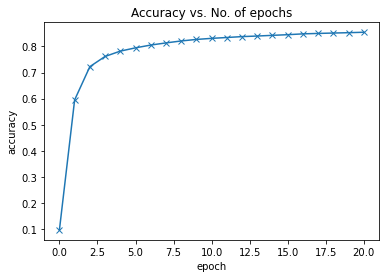

In [44]:
# Replace these values with your results
history = [result0] + history1 + history2 + history3 + history4
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

## Testing with individual images

In [45]:
# Define test dataset
test_dataset = MNIST(root='data/', 
                     train=False,
                     transform=transforms.ToTensor())

Shape: torch.Size([1, 28, 28])
Label: 7


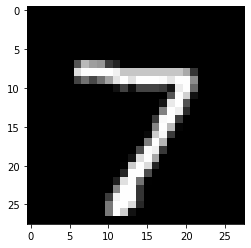

In [46]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Shape:', img.shape)
print('Label:', label)

In [47]:
img.unsqueeze(0).shape

torch.Size([1, 1, 28, 28])

In [48]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

`img.unsqueeze` simply adds another dimension at the begining of the 1x28x28 tensor, making it a 1x1x28x28 tensor, which the model views as a batch containing a single image.



Label: 7 , Predicted: 7


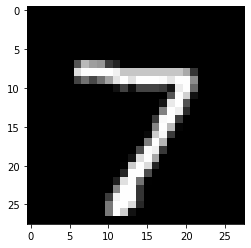

In [49]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 0 , Predicted: 0


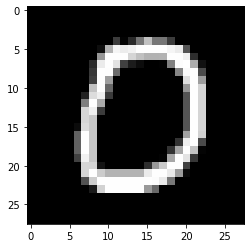

In [50]:
img, label = test_dataset[10]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

In [53]:
test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model, test_loader)
result

{'val_loss': 0.6414589285850525, 'val_acc': 0.861621081829071}

## Saving and loading the model

Since we've trained our model for a long time and achieved a resonable accuracy, it would be a good idea to save the weights and bias matrices to disk, so that we can reuse the model later and avoid retraining from scratch.

In [54]:
torch.save(model.state_dict(), 'mnist-logistic.pth')

The `.state_dict` method returns an `OrderedDict` containing all the weights and bias matrices mapped to the right attributes of the model.

In [55]:
model.state_dict()

OrderedDict([('linear.weight',
              tensor([[ 2.9476e-02,  1.6095e-04,  2.7680e-02,  ..., -1.0174e-03,
                        4.3108e-03, -1.1998e-02],
                      [ 2.4589e-02,  1.9087e-02,  3.2779e-02,  ...,  2.6337e-02,
                       -3.3153e-02,  2.7393e-02],
                      [ 1.1093e-02, -6.4410e-04,  3.2344e-02,  ..., -3.3768e-02,
                        3.6893e-03,  4.1621e-04],
                      ...,
                      [ 2.5873e-02, -1.4554e-02,  3.1569e-02,  ...,  6.7205e-03,
                        2.2008e-02,  3.0912e-02],
                      [ 2.4948e-02, -7.8108e-04, -2.1335e-02,  ...,  2.3754e-02,
                       -4.3130e-03, -1.4235e-02],
                      [ 3.2023e-02, -1.4052e-02, -1.4928e-02,  ..., -6.1575e-05,
                       -1.5353e-02, -2.6251e-04]])),
             ('linear.bias',
              tensor([-0.0457,  0.0822,  0.0104, -0.0458,  0.0005,  0.0635,  0.0090,  0.0229,
                      -0.1011,

To load the model weights, we can instante a new object of the class `MnistModel`, and use the `.load_state_dict` method.

In [56]:
model2 = MnistModel()
model2.load_state_dict(torch.load('mnist-logistic.pth'))
model2.state_dict()

OrderedDict([('linear.weight',
              tensor([[ 2.9476e-02,  1.6095e-04,  2.7680e-02,  ..., -1.0174e-03,
                        4.3108e-03, -1.1998e-02],
                      [ 2.4589e-02,  1.9087e-02,  3.2779e-02,  ...,  2.6337e-02,
                       -3.3153e-02,  2.7393e-02],
                      [ 1.1093e-02, -6.4410e-04,  3.2344e-02,  ..., -3.3768e-02,
                        3.6893e-03,  4.1621e-04],
                      ...,
                      [ 2.5873e-02, -1.4554e-02,  3.1569e-02,  ...,  6.7205e-03,
                        2.2008e-02,  3.0912e-02],
                      [ 2.4948e-02, -7.8108e-04, -2.1335e-02,  ...,  2.3754e-02,
                       -4.3130e-03, -1.4235e-02],
                      [ 3.2023e-02, -1.4052e-02, -1.4928e-02,  ..., -6.1575e-05,
                       -1.5353e-02, -2.6251e-04]])),
             ('linear.bias',
              tensor([-0.0457,  0.0822,  0.0104, -0.0458,  0.0005,  0.0635,  0.0090,  0.0229,
                      -0.1011,

In [57]:
test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model2, test_loader)
result

{'val_loss': 0.6414589285850525, 'val_acc': 0.861621081829071}